In [ ]:
import os
import sys
import time
import numpy as np
import pandas as pd
import scipy as sp
from typing import List
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm, ticker
from astropy.io import fits
import astropy.io.ascii as astropy_ascii
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord

src_dir = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/src'
if not src_dir in sys.path: sys.path.append(src_dir)
utils_dir = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/src/utils'
if not utils_dir in sys.path: sys.path.append(utils_dir)
from constants import *
from CosmoFunc import *

from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.special import erf

from matplotlib.ticker import FormatStrFormatter

from step_8_fit_logdist import fit_logdist

# Plot configurations
GOLDEN_RATIO = 0.5*(1+np.sqrt(5))
FIGURE_HEIGHT = 5
FIGURE_WIDTH = FIGURE_HEIGHT*GOLDEN_RATIO
DEFAULT_FIGSIZE = (FIGURE_WIDTH, FIGURE_HEIGHT)

# ROOT_PATH = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0'
from dotenv import load_dotenv 
load_dotenv()

ROOT_PATH = os.environ.get('ROOT_PATH')
SMIN_SETTING = int(os.environ.get('SMIN_SETTING'))
FP_SETTING = int(os.environ.get('FP_SETTING'))

LCDM = [OMEGA_M, 1.0 - OMEGA_M, 0., 100., -1., 0., 0.]

# 1. Get SuperGalactic Coordinates

In [2]:
def get_supergalactic_coords(
        df: pd.DataFrame,
        ra_col_name: str = 'ra',
        dec_col_name: str = 'dec',
        z_dist_est_col_name: str = 'z_dist_est'
    ) -> pd.DataFrame:
    
    # Fetch ra and dec
    ra = df[ra_col_name].to_numpy()
    dec = df[dec_col_name].to_numpy()
    
    # Construct astropy coords object
    eq_coords = SkyCoord(ra=ra * u.degree, dec=dec * u.degree, frame='fk5')
    
    # Convert to supergalactic coordinates
    sgal_coords = eq_coords.supergalactic
    sgl = sgal_coords.sgl.degree
    sgb = sgal_coords.sgb.degree
    df['SGLON'] = sgl
    df['SGLAT'] = sgb
    
    # Get comoving distances
    myfunc = np.vectorize(DistDc)
    dz = myfunc(df[z_dist_est_col_name].to_numpy(), *LCDM)
    
    # Get supergalactic cartesian coordinates
    sgx = dz*np.cos(np.radians(sgb))*np.cos(np.radians(sgl))
    sgy = dz*np.cos(np.radians(sgb))*np.sin(np.radians(sgl))
    sgz = dz*np.sin(np.radians(sgb))
    
    df['dz_dist_est'] = dz
    df['SGX'] = sgx
    df['SGY'] = sgy
    df['SGZ'] = sgz
    
    return df

In [11]:
# Test on 6dFGS
filepath = f"../data/foundation/logdist/smin_setting_1/fp_setting_0/6dfgs.csv"
df = pd.read_csv(filepath)

df = get_supergalactic_coords(df)

df[['z_dist_est', 'dz_dist_est']].head()

,z_dist_est,dz_dist_est
0,0.037063,110.142623
1,0.049740,147.365494
2,0.034571,102.798400
3,0.048854,144.769963
4,0.048854,144.769963


In [12]:
df

,tmass,_6dFGS,ra,dec,zhelio,z_cmb,z_dist_est,j_m_ext,extinction_j,kcor_j,...,logdist_scale,logdist_mean_cf,logdist_std_cf,logdist_chisq_cf,SGLON,SGLAT,dz_dist_est,SGX,SGY,SGZ
0,2MASXJ00002213-0137463,g0000222-013746,0.09225,-1.62947,0.0383,0.037063,0.037063,12.625,0.025941,-0.024528,...,0.114091,0.087546,0.100259,0.366278,291.080704,12.684264,110.142623,38.649542,-100.263152,24.184927
1,2MASXJ00002509-2602401,g0000251-260240,0.10455,-26.04450,0.0508,0.049740,0.049740,12.495,0.011846,-0.030792,...,0.127224,0.164668,0.109649,0.596797,267.645546,4.888790,147.365494,-6.031958,-146.705423,12.558780
2,2MASXJ00004283-7217148,g0000428-721715,0.17835,-72.28741,0.0348,0.034571,0.034571,12.942,0.024897,-0.022005,...,0.138668,-0.036261,0.118002,0.801387,223.978815,-10.904231,102.798400,-72.637771,-70.093594,-19.446164
3,2MASXJ00005234-3550370,g0000523-355037,0.21810,-35.84367,0.0520,0.051073,0.048854,12.127,0.008305,-0.036756,...,0.140060,-0.008168,0.121788,0.499007,258.480072,1.380881,144.769963,-28.903433,-141.812420,3.488752
4,2MASXJ00005317-3559104,g0000532-355911,0.22155,-35.98631,0.0500,0.049077,0.048854,12.445,0.009257,-0.026408,...,0.132118,0.028354,0.115332,0.449141,258.347480,1.328124,144.769963,-29.232167,-141.748240,3.355487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6969,2MASXJ23581801-5357144,g2358180-535715,359.57490,-53.95403,0.0312,0.030598,0.030598,13.054,0.008978,-0.026212,...,0.129007,-0.014145,0.110730,0.653927,241.364513,-4.597631,91.069541,-43.503326,-79.673290,-7.299926
6970,2MASXJ23585980-5527301,g2358598-552730,359.74905,-55.45833,0.0111,0.010538,0.010538,9.217,0.007586,-0.008959,...,0.104957,-0.015837,0.099551,0.023528,239.984855,-5.216929,31.515195,-15.699507,-27.175752,-2.865577
6971,2MASXJ23585991-6200483,g2358599-620048,359.74965,-62.01342,0.0303,0.029857,0.029857,12.242,0.012499,-0.021229,...,0.109102,0.114655,0.098484,0.173277,233.785806,-7.456254,88.881319,-52.067551,-71.104321,-11.534056
6972,2MASXJ23591929-3143478,g2359193-314348,359.83050,-31.72992,0.0280,0.027034,0.027034,12.172,0.011255,-0.021255,...,0.120174,-0.063852,0.104627,0.465190,262.219723,3.131421,80.531819,-10.885678,-79.671345,4.399164


# 2. Get Smoothing Length for Each Galaxy

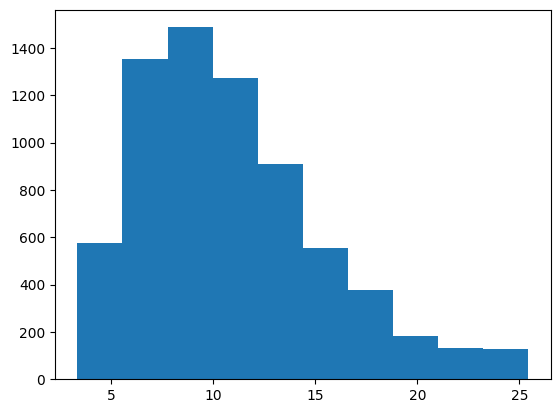

In [13]:
sigma_fid = 5.0
scale = 5

# Get supergalactic coordinates vector for each galaxy
coords_data = np.array([df['SGX'], df['SGY'], df['SGZ']]).T

def get_smoothing_length(coord_x, coord_y, coord_z, coords_data, sigma_fid=5.0, scale=5, tol_=1e-10):
    """
    A function to calculate the smoothing length for every galaxy.
    """
    # Construct vector from the coordinates
    coord_j = np.array([coord_x, coord_y, coord_z])
    # Calculate distances from galaxy j to every other galaxy (including itself)
    distances = np.sqrt(np.sum((coord_j - coords_data)**2, axis=1))
    # Filter galaxies within scale * sigma_fid
    distances = distances[distances <= scale * sigma_fid]
    
    # Calculate local density for each galaxy
    delta_j = np.sum(np.exp(-0.5 * (distances / sigma_fid)**2))

    return delta_j

df['delta_j'] = df.apply(lambda x: get_smoothing_length(x.SGX, x.SGY, x.SGZ, coords_data, sigma_fid=sigma_fid, scale=scale), axis=1)
df['sigma_j'] = 2 * sigma_fid * np.sqrt(np.exp(np.log(df['delta_j']).sum() / len(df)) / df['delta_j'])

plt.hist(df['sigma_j'])
plt.show()

# 3. Get Smoothed Logdist Field

In [16]:
def get_grids(
    x_start: float = -300.,
    x_end: float = 300., 
    y_start: float = -300., 
    y_end: float = 300., 
    z_list: List[float] = [-80., -30., 10., 70.], 
    grid_width: float = 4.0, 
    max_dist: float = 200., 
    remove_galactic_plane: bool = True, 
    remove_ncp: bool = False
) -> np.ndarray:
    
    # Create grids
    grid_x = np.arange(x_start, x_end, grid_width)
    grid_y = np.arange(y_start, y_end, grid_width)
    grid_z = np.array(z_list)
    
    coords_grid = np.array(np.meshgrid(grid_x, grid_y, grid_z)).T.reshape(-1, 3)
    
    # Remove origin and edges
    grid_dist = np.sqrt(np.sum(coords_grid**2, axis=1))
    coords_grid = coords_grid[np.logical_and(grid_dist < max_dist, grid_dist > 0.)]
    
    # Remove the galactic plane
    if remove_galactic_plane:
        # Convert to SGLAT and SGLON
        grid_dist = np.sqrt(np.sum(coords_grid**2,axis=1))
        sglat_grid = np.arcsin(coords_grid[:,2]/grid_dist)
        sglon_grid = np.arctan(coords_grid[:,1]/coords_grid[:,0])

        # Two solutions
        sglon_grid_1 = sglon_grid
        sglon_grid_1[sglon_grid_1<0.] += 2*np.pi
        sglon_grid_2 = sglon_grid + np.pi
        sglon_grid_2[sglon_grid_2<0.] += 2*np.pi
        sglon_grid_2[sglon_grid_2>2*np.pi] -= 2*np.pi

        # Check the quadrant
        x = coords_grid[:,0]; y = coords_grid[:,1]
        for i in range(len(sglon_grid)):
            if (y[i] > 0. and x[i] > 0.):
                if (0. < sglon_grid_1[i] < 0.5 * np.pi):
                    sglon_grid[i] = sglon_grid_1[i]
                elif (0 < sglon_grid_2[i] < 0.5 * np.pi):
                    sglon_grid[i] = sglon_grid_2[i]
            elif (y[i] > 0. and x[i] < 0.):
                if (0.5 * np.pi < sglon_grid_1[i] < np.pi):
                    sglon_grid[i] = sglon_grid_1[i]
                elif (0.5 * np.pi < sglon_grid_2[i] < np.pi):
                    sglon_grid[i] = sglon_grid_2[i]
            elif (y[i] < 0. and x[i] < 0.):
                if (np.pi < sglon_grid_1[i] < 1.5 * np.pi):
                    sglon_grid[i] = sglon_grid_1[i]
                elif (np.pi < sglon_grid_2[i] < 1.5 * np.pi):
                    sglon_grid[i] = sglon_grid_2[i]
            elif (y[i] < 0. and x[i] > 0.):
                if (1.5 * np.pi < sglon_grid_1[i] < 2 * np.pi):
                    sglon_grid[i] = sglon_grid_1[i]
                elif (1.5 * np.pi < sglon_grid_2[i] < 2 * np.pi):
                    sglon_grid[i] = sglon_grid_2[i]

        # Convert to degrees
        sglat_grid = np.degrees(sglat_grid); sglon_grid = np.degrees(sglon_grid)            

        c_sg_grid = SkyCoord(sglon_grid, sglat_grid, unit='deg', frame ='supergalactic')
        c_gal_grid = c_sg_grid.transform_to('galactic')
        gal_lon_grid = c_gal_grid.l.value
        gal_lat_grid = c_gal_grid.b.value

        # Remove gridpoints near the NCP
        # 90 < l < 140, 0 < b < 40 (eyeballing)
        crit1 = np.logical_and(gal_lon_grid>90.,gal_lon_grid<140.)
        crit2 = np.logical_and(gal_lat_grid>0.,gal_lat_grid<40.)

        # Remove gridpoints on the Galactic plane (|b| > 10d)
        crit3 = np.absolute(gal_lat_grid)>=10.
        
        if not remove_ncp:
            coords_grid = coords_grid[crit3]
        else:
            criteria = (crit1 & crit2) | ~crit3
            coords_grid = coords_grid[~criteria]
            
    return coords_grid

In [17]:
def get_smoothed_field(
    df: pd.DataFrame,
    logdist_col: str,
    logdist_err_col: str,
    scale: int = 3
) -> pd.DataFrame:
    
    # Convert data to numpy arrays
    logdist = df[logdist_col].to_numpy()
    logdist_err = df[logdist_err_col].to_numpy()
    smoothing_length = df['sigma_j'].to_numpy()
    coords_data = np.array([df['SGX'], df['SGY'], df['SGZ']]).T

    # Create empty dataframe to store smoothed logdist field
    df_smoothed = pd.DataFrame()
    coords_grid = get_grids()
    df_smoothed[['SGX', 'SGY', 'SGZ']] = coords_grid

    # Determine N_j for each point i, calculate distance from every point to every galaxy
    distances = np.sqrt(np.sum((coords_grid[:, None] - coords_data)**2, axis=2))
    mask = distances <= scale * smoothing_length
    N_j = np.sum(mask, axis=1)

    # Calculate cosine of the angle between grid position and galaxy's position
    grid_dist = np.sqrt(np.sum(coords_grid**2, axis=1))
    gal_dist = np.sqrt(np.sum(coords_data**2, axis=1))
    cos_theta = np.sum(coords_grid[:, None] * coords_data, axis=2) / (grid_dist[:, None] * gal_dist)

    # Calculate the smoothed logdist for each grid and its estimated error
    weight = 1 #logdist_err ** (-2) (not sure why in my latest version I didn't include weight)
    num_ = np.sum(mask * weight * logdist * cos_theta * np.exp(-0.5 * (distances / smoothing_length)**2) * (smoothing_length**(-3)), axis=1)
    num_err_ = np.sum(mask * weight * logdist_err * cos_theta * np.exp(-0.5 * (distances / smoothing_length)**2) * (smoothing_length**(-3)), axis=1)
    denom_ = np.sum(mask * weight * np.exp(-0.5 * (distances / smoothing_length)**2) * (smoothing_length**(-3)), axis=1)
    
    # Save to the dataframe
    df_smoothed['logdist_smoothed'] = num_ / denom_
    df_smoothed['logdist_smoothed_err'] = num_err_ / denom_
    
    return df_smoothed

df_smoothed = get_smoothed_field(df, 'logdist_mean_cf', 'logdist_std_cf')

/var/folders/50/_r7c0z0x3bl4zx6npn1b1x480000gn/T/ipykernel_3535/1711183180.py:29: RuntimeWarning: divide by zero encountered in divide
  sglon_grid = np.arctan(coords_grid[:,1]/coords_grid[:,0])
/var/folders/50/_r7c0z0x3bl4zx6npn1b1x480000gn/T/ipykernel_3535/1711183180.py:29: RuntimeWarning: invalid value encountered in divide
  sglon_grid = np.arctan(coords_grid[:,1]/coords_grid[:,0])
/var/folders/50/_r7c0z0x3bl4zx6npn1b1x480000gn/T/ipykernel_3535/2341302249.py:36: RuntimeWarning: invalid value encountered in divide
  df_smoothed['logdist_smoothed'] = num_ / denom_
/var/folders/50/_r7c0z0x3bl4zx6npn1b1x480000gn/T/ipykernel_3535/2341302249.py:37: RuntimeWarning: invalid value encountered in divide
  df_smoothed['logdist_smoothed_err'] = num_err_ / denom_


In [18]:
df_smoothed

,SGX,SGY,SGZ,logdist_smoothed,logdist_smoothed_err
0,-180.0,-32.0,-80.0,0.172300,0.149075
1,-180.0,-28.0,-80.0,0.172154,0.148949
2,-176.0,-48.0,-80.0,0.067652,0.140352
3,-176.0,-44.0,-80.0,0.072399,0.140665
4,-176.0,-40.0,-80.0,0.077180,0.140949
...,...,...,...,...,...
25137,180.0,40.0,70.0,NaN,NaN
25138,180.0,44.0,70.0,NaN,NaN
25139,180.0,48.0,70.0,NaN,NaN
25140,184.0,28.0,70.0,NaN,NaN


# 4. Plot Logdist Field for Different Slices in SGZ

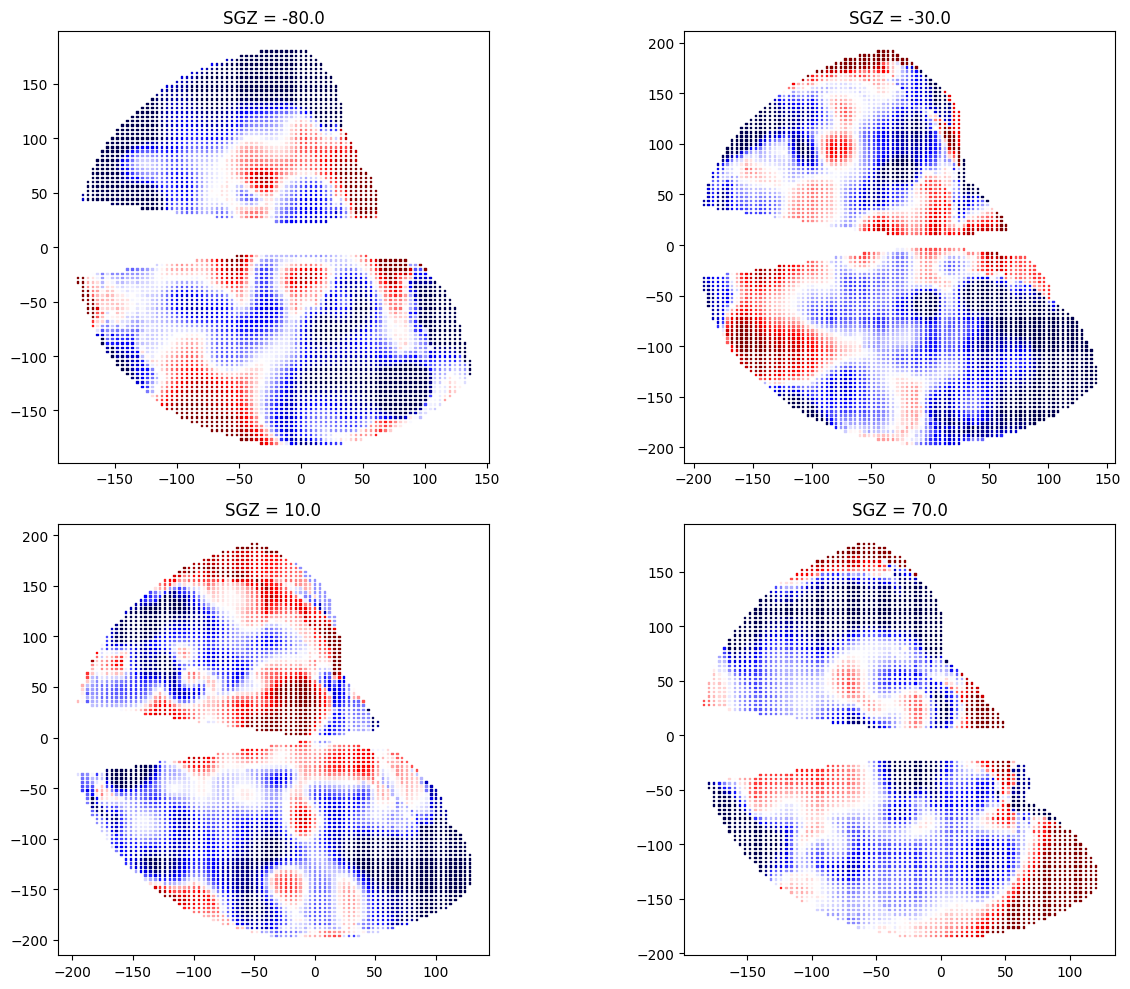

In [239]:
vmin = -0.05
vmax = 0.05
SGZ_list = df_smoothed['SGZ'].unique()

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(FIGURE_WIDTH * 2, FIGURE_HEIGHT * 2))

for i, ax in enumerate(fig.axes):
    z = SGZ_list[i]
    data = df_smoothed[df_smoothed['SGZ'] == z]
    x = data['SGX']
    y = data['SGY']
    logdist = data['logdist_smoothed']
    logdist_err = data['logdist_smoothed_err']

    plt.set_cmap('seismic')
    ax.scatter(x, y, c=logdist, marker='s', s=1, vmin=vmin, vmax=vmax)
    ax.set_title(f"SGZ = {z}")
#     ax.set_aspect('equal', adjustable='box')
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    fig.tight_layout()

# Put everything together

In [19]:
INPUT_FILEPATH = {
    "6dFGS": f'../data/foundation/logdist/smin_setting_{SMIN_SETTING}/fp_setting_{FP_SETTING}/6dfgs.csv',
    "CF4": "../data/external/logdist/CF4_6dF.csv",
    "SDSS": f'../data/foundation/logdist/smin_setting_{SMIN_SETTING}/fp_setting_{FP_SETTING}/sdss.csv',
    "H22": f'../data/external/logdist/cullan_logdist.csv',
}

OUTPUT_FILEPATH = {
    "6dFGS": f"../scrap/smoothed_field/smin_setting_{SMIN_SETTING}/fp_setting_{FP_SETTING}/6dfgs.csv",
    "CF4": f"../scrap/smoothed_field/smin_setting_{SMIN_SETTING}/fp_setting_{FP_SETTING}/cf4.csv",
    "SDSS": f"../scrap/smoothed_field/smin_setting_{SMIN_SETTING}/fp_setting_{FP_SETTING}/sdss.csv",
    "H22": f"../scrap/smoothed_field/smin_setting_{SMIN_SETTING}/fp_setting_{FP_SETTING}/h22_full.csv"
}
create_parent_folder(OUTPUT_FILEPATH)

# User-defined variable
SIGMA_FID = 4.0
SCALE = 3.0

for survey in ['H22']:
    # Load the data
    logdist_filepath = INPUT_FILEPATH[survey]
    df = pd.read_csv(logdist_filepath)

    if survey == 'CF4':
        # Only fetch common galaxies with my data
        my_id = pd.read_csv("../data/foundation/logdist/smin_setting_1/fp_setting_0/6dfgs.csv")[['_6dFGS']]
        df = df.merge(my_id, left_on="Name", right_on="_6dFGS", how="inner")
        df['ra'] = df['RA']
        df['dec'] = df['DE']
        df['logdist_mean_cf'] = df['DzDh']
        df['logdist_std_cf'] = df['DzDh']
        df['z_dist_est'] = df['Vg'] / LIGHTSPEED
    elif survey == 'H22':
        my_id = pd.read_csv("../data/foundation/logdist/smin_setting_1/fp_setting_0/sdss.csv")[['objid']]
        df['objid'] = df['objid'].apply(lambda x: 'SDSS' + str(x))
#         df = df.merge(my_id, on="objid", how="inner")
        df['ra'] = df['RA']
        df['dec'] = df['Dec']
        df['logdist_mean_cf'] = df['logdist']
        df['logdist_std_cf'] = df['logdist_err']
        df['z_dist_est'] = df['zcmb_group']
        df = df[df['z_dist_est'] < 0.06]
        
    
    print(f"Number of galaxies in {survey} = {len(df)}")
    # Get supergalactic coordinates
    df = get_supergalactic_coords(df)
    
    # Get array of coordinates (SGX, SGY, SGZ) for all galaxies
    print("Getting supergalactic coordinates...")
    coords_data = np.array([df['SGX'], df['SGY'], df['SGZ']]).T
    
    # Calculate local density and smoothing length
    print("Calculating local density and smoothing length...")
    df['delta_j'] = df.apply(lambda x: get_smoothing_length(x.SGX, x.SGY, x.SGZ, coords_data, sigma_fid=SIGMA_FID, scale=SCALE), axis=1)
    df['sigma_j'] = 2 * SIGMA_FID * np.sqrt(np.exp(np.log(df['delta_j']).sum() / len(df)) / df['delta_j'])
    
    # Get smoothed logdist field
    print("Calculating smoothed logdist field...")
    df_smoothed = get_smoothed_field(df, 'logdist_mean_cf', 'logdist_std_cf', scale=SCALE)
    
    # Save smoothed logdist field
    output_filepath = OUTPUT_FILEPATH[survey]
    df_smoothed.to_csv(output_filepath, index=False)

Number of galaxies in H22 = 11153
Getting supergalactic coordinates...
Calculating local density and smoothing length...
Calculating smoothed logdist field...


/var/folders/50/_r7c0z0x3bl4zx6npn1b1x480000gn/T/ipykernel_3535/1711183180.py:29: RuntimeWarning: divide by zero encountered in divide
  sglon_grid = np.arctan(coords_grid[:,1]/coords_grid[:,0])
/var/folders/50/_r7c0z0x3bl4zx6npn1b1x480000gn/T/ipykernel_3535/1711183180.py:29: RuntimeWarning: invalid value encountered in divide
  sglon_grid = np.arctan(coords_grid[:,1]/coords_grid[:,0])
/var/folders/50/_r7c0z0x3bl4zx6npn1b1x480000gn/T/ipykernel_3535/2341302249.py:36: RuntimeWarning: invalid value encountered in divide
  df_smoothed['logdist_smoothed'] = num_ / denom_
/var/folders/50/_r7c0z0x3bl4zx6npn1b1x480000gn/T/ipykernel_3535/2341302249.py:37: RuntimeWarning: invalid value encountered in divide
  df_smoothed['logdist_smoothed_err'] = num_err_ / denom_


# 5. Compare with External Data

In [ ]:
def generate_field_comparison(
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    df1_label: str,
    df2_label: str,
    figure_size: int = 10,
    vmin: float = -0.05,
    vmax: float = 0.05,
    markersize: float = 1
) -> None:
    # DataFrame to store the comparison
    df = pd.DataFrame()
    df['SGX'] = df1['SGX']
    df['SGY'] = df1['SGY']
    df['SGZ'] = df1['SGZ']
    df['delta_logdist'] = df1['logdist_smoothed'] - df2['logdist_smoothed']
    df['delta_logdist_err'] = np.sqrt(df1['logdist_smoothed_err']**2 + df2['logdist_smoothed_err']**2)
    df['chi'] = df['delta_logdist'] / df['delta_logdist_err']
    
    # Get list of SGZ
    SGZ_list = sorted(df['SGZ'].unique().tolist(), reverse=True)
    
    ncols = 4
    nrows = len(SGZ_list)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(figure_size*((nrows+1)/ncols), figure_size*(nrows/ncols)))
    
    plt.rcParams['axes.facecolor'] = '#D3D3D3'
    plt.set_cmap('seismic')
    
    # Iterate through the SGZ slices
    for i, sgz in enumerate(SGZ_list):
        # First column (my measurements)
        temp_1 = df1[df1['SGZ'] == sgz]
        left_plot = ax[i, 0].scatter(temp_1['SGX'], temp_1['SGY'], marker='s', c=temp_1['logdist_smoothed'], s=markersize, vmin=vmin, vmax=vmax)
        cbar = plt.colorbar(left_plot, ax=ax[i, 0])
    #     cbar.set_label(label=r'$\eta_\mathrm{data}$', size=14) 

        # Second column (external measurements)
        temp_2 = df2[df2['SGZ'] == sgz]
        middle_plot = ax[i, 1].scatter(temp_2['SGX'], temp_2['SGY'], marker='s', c=temp_2['logdist_smoothed'], s=markersize, vmin=vmin, vmax=vmax)
        cbar = plt.colorbar(middle_plot, ax=ax[i, 1])
    #     cbar.set_label(label=r'$\eta_\mathrm{CF4}$', size=14) 

        # Third column (Difference between data and CF4)
        temp = df[df['SGZ'] == sgz]
        middle_plot = ax[i, 2].scatter(temp['SGX'], temp['SGY'], marker='s', c=temp['delta_logdist'], s=markersize, vmin=-.05, vmax=.05)
        cbar = plt.colorbar(middle_plot, ax=ax[i, 2])
    #     cbar.set_label(label=r'$\eta_\mathrm{CF4}$', size=14) 

        # Fourth column (Comparisons)
        temp = df[df['SGZ'] == sgz]
        right_plot = ax[i, 3].scatter(temp['SGX'], temp['SGY'], marker='s', c=temp['chi'], s=markersize, vmin=-3., vmax=3.)
        cbar = plt.colorbar(right_plot, ax=ax[i, 3])
    #     cbar.set_label(label=r'$\epsilon$', size=14)
    
    # Set labels
    ax[0, 0].set_title(f'{df1_label}_logdist', size=14)
    ax[0, 1].set_title(f'{df2_label}_logdist', size=14)
    ax[0, 2].set_title(f'{df1_label}_logdist - {df2_label}_logdist', size=12)
    ax[0, 3].set_title(r'$\epsilon$', size=14)

    for i in range(nrows):
    #     ax[i, 0].set_ylabel(r"SGY ($h^{-1}$ Mpc)", fontsize=14)
        ax[i, 0].set_ylabel(fr"SGZ = {SGZ_list[i]} $/h$ Mpc", fontsize=10)
    for j in range(ncols):
        ax[-1, j].set_xlabel(r"SGX ($h^{-1}$ Mpc)", fontsize=14)

## 5. 1. Compare 6dFGS with CF4

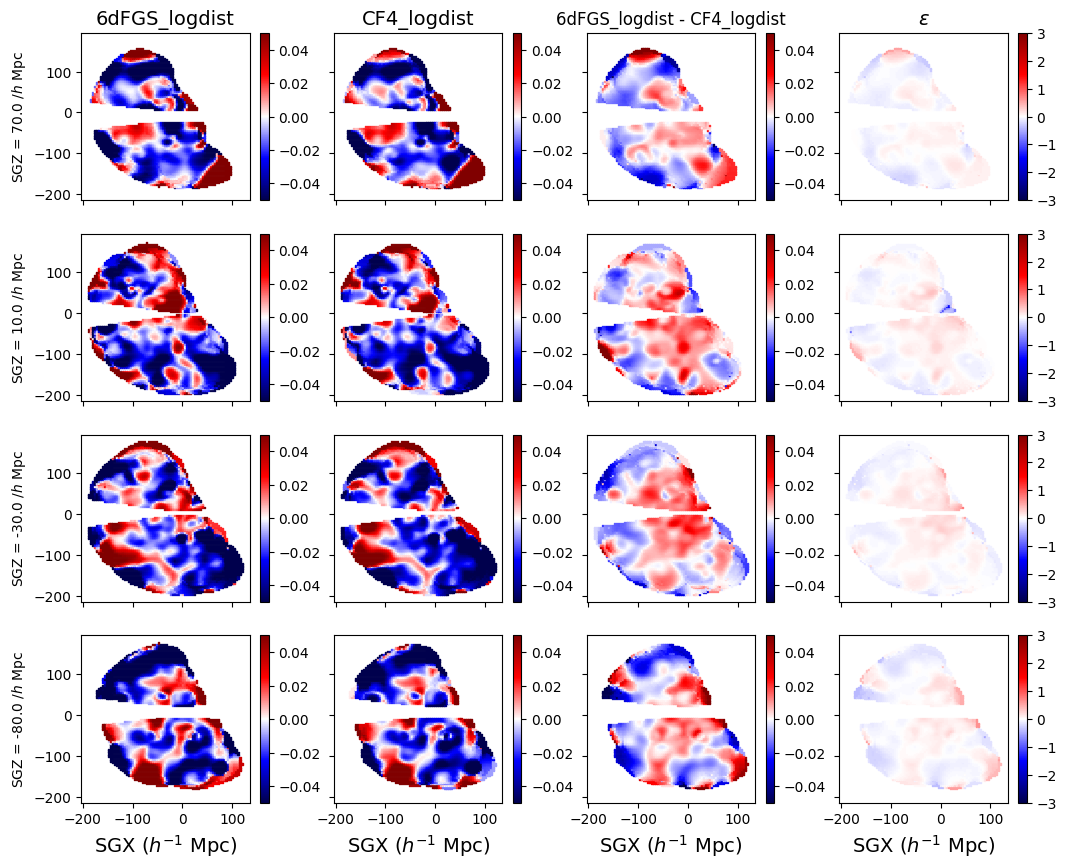

In [5]:
# Load the smoothed data
smoothed_cf4 = pd.read_csv(f'../scrap/smoothed_field/smin_setting_0/fp_setting_1/cf4.csv')
smoothed_6df = pd.read_csv(f'../scrap/smoothed_field/smin_setting_0/fp_setting_1/6dfgs.csv')

generate_field_comparison(smoothed_6df, smoothed_cf4, '6dFGS', 'CF4')

## 5. 2. Compare SDSS with H22

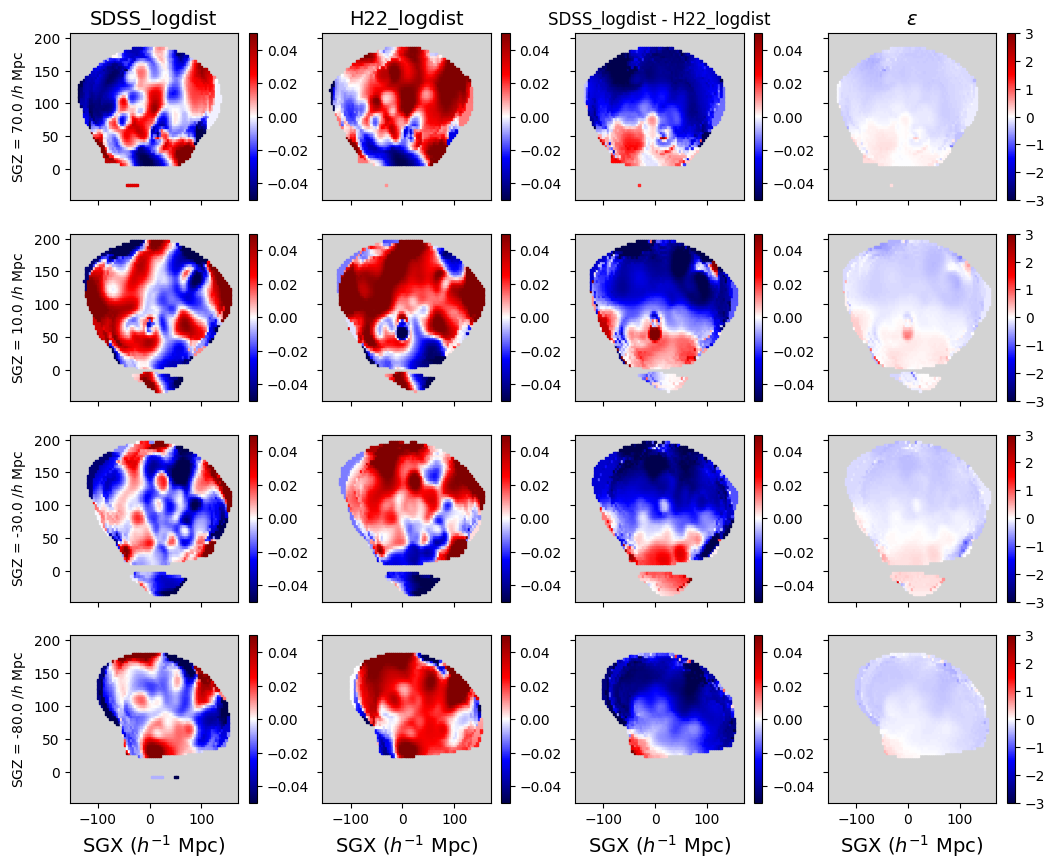

In [6]:
# Load the smoothed data
mydata_smoothed = pd.read_csv(f'../scrap/smoothed_field/smin_setting_1/fp_setting_0/sdss.csv')
externaldata_smoothed = pd.read_csv(f'../scrap/smoothed_field/smin_setting_1/fp_setting_0/h22.csv')

generate_field_comparison(mydata_smoothed, externaldata_smoothed, 'SDSS', 'H22', markersize=2)